In [1]:
import pandas as pd
import pandas_datareader
from pandas_datareader import data
# Set the start and end date
start_date = '2020-03-01'
end_date = '2021-03-01'
# Set the ticker
ticker = 'AMZN'
# Get the data
data = data.get_data_yahoo(ticker, start_date, end_date)
data.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-03-02,1954.510010,1870.000000,1906.489990,1953.949951,6761700,1953.949951
2020-03-03,1996.329956,1888.089966,1975.369995,1908.989990,7534500,1908.989990
2020-03-04,1978.000000,1922.000000,1946.569946,1975.829956,4772900,1975.829956
2020-03-05,1960.719971,1910.000000,1933.000000,1924.030029,4748200,1924.030029
2020-03-06,1910.869995,1869.500000,1875.000000,1901.089966,5273600,1901.089966


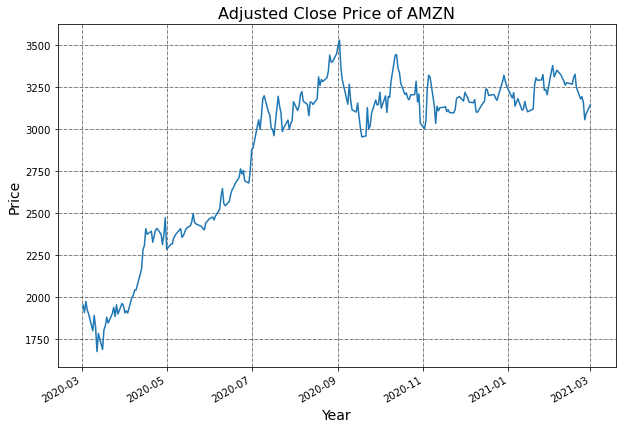

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
# Plot the adjusted close price
data['Adj Close'].plot(figsize=(10, 7))
# Define the label for the title of the figure
plt.title("Adjusted Close Price of %s" % ticker, fontsize=16)
# Define the labels for x-axis and y-axis
plt.ylabel('Price', fontsize=14)
plt.xlabel('Year', fontsize=14)
# Plot the grid lines
plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
# Show the plot
plt.show()

In [3]:
import numpy as np

data['Log returns'] = np.log(data['Adj Close']/data['Adj Close'].shift())

In [4]:
volatility_12m = data['Log returns'].std()*252**.5
volatility_12m

0.3794292915174012

Text(0.5, 1.0, 'AMZN 12m volatility: 37.940000000000005%')

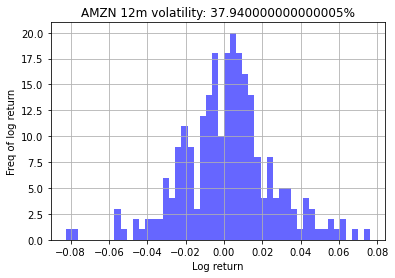

In [5]:
str_vol = str(round(volatility_12m, 4)*100)

fig, ax = plt.subplots()
data['Log returns'].hist(ax=ax, bins=50, alpha=0.6, color='b')
ax.set_xlabel("Log return")
ax.set_ylabel("Freq of log return")
ax.set_title("AMZN 12m volatility: " + str_vol + "%")

In [6]:
volatility_6m = data['Log returns'].std()*126**.5
volatility_6m

0.26829702501276176

Text(0.5, 1.0, 'AMZN 6m volatility: 26.83%')

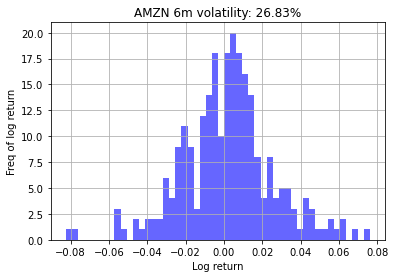

In [16]:
str_vol = str(round(volatility_6m, 4)*100)

fig, ax = plt.subplots()
data['Log returns'].hist(ax=ax, bins=50, alpha=0.6, color='b')
ax.set_xlabel("Log return")
ax.set_ylabel("Freq of log return")
ax.set_title("AMZN 6m volatility: " + str_vol + "%")

In [7]:
#Monte Carlo Simulation (MC)
import datetime
import math
from random import gauss
from math import exp, sqrt

def generate_asset_price(S,v,r,T):
    return S * exp((r - 0.5 * v**2) * T + v * sqrt(T) * gauss(0,1.0))

def call_payoff(S_T,K):
    return max(0.0,S_T-K)

S = 1953.95 # underlying price
v = 0.3794 # vol of 37.94%
r = 0.0014 # rate of 0.14%
T = 30
K = 1960
simulations = 90000
payoffs = []
discount_factor = math.exp(-r * T)

for i in list(range(simulations)):
    S_T = generate_asset_price(S,v,r,T)
    payoffs.append(
        call_payoff(S_T, K)
    )

price = discount_factor * (sum(payoffs) / float(simulations))
print('Price: %.4f' % price)

Price: 1364.9938


In [8]:
#Black Schole Model (BSM)
import random
from math import exp, sqrt

def gbm(S, v, r, T):
    return S * exp((r - 0.5 * v**2) * T + v * sqrt(T) * random.gauss(0,1.0))

def binary_call_payoff(K, S_T):
    if S_T >= K:
        return 1.0
    else:
        return 0.0

# parameters
S = 1953.95 # asset price
v = 0.3794 # vol of 37.94%
r = 0.0014 # rate of 0.14%
maturity = 30
K = 1960 # strike
simulations = 50000
payoffs = 0.0

# run simultaion
for i in list(range(simulations)):
    S_T = gbm(S, v, r, maturity)
    payoffs += binary_call_payoff(K, S_T)

# find prices
option_price = exp(-r * maturity) * (payoffs / float(simulations))

print('Price: %.8f' % option_price)

Price: 0.14392635


In [21]:
from scipy.stats import norm
import numpy as np
def d(sigma,S,K,r,T):
    d1=1/(sigma*np.sqrt(T))*(np.log(S/K)+(r+sigma**2/2)*T)
    d2=d1-sigma*np.sqrt(T)
    return d1,d2

def Price(S, K, r, sigma, T,d1,d2):
    P=-norm.cdf(-d1)*S+norm.cdf(-d2)*K*np.exp(-r*T)
    return P
def delta(d_1):
    return -norm.cdf(-d_1)
#Input parameters:
S= 1953.95 #asset price
K=1960 #strike price
r=0.0014 #interest rate
sigma=0.3794 #volatility
T=30 #time to maturity
d1,d2=d(sigma,S,K,r,T)
print("d1= ", d1)
print("d2= ", d2)

d1=  1.057753165916026
d2=  -1.0203062172585742


In [22]:
delta_put=delta(d1)
print("Delta= ", delta_put)

Delta=  -0.14508399485296208


In [24]:
def gamma(d2,S,K,sigma,r,T):
    return(K*np.exp(-r*T)*(norm.pdf(d2)/(S**2*sigma*np.sqrt(T))))
print("Gamma= ", gamma(d2,S,K,sigma,r,T))

Gamma=  5.6154590477288834e-05


In [25]:
def theta(d1,d2,S,K,sigma,r,T):
    theta=-S*sigma*norm.pdf(-d1)/(2*np.sqrt(T))+r*K*np.exp(-r*T)*norm.cdf(-d2)
    return theta
print("Theta= ", theta(d1,d2,S,K,sigma,r,T))    

Theta=  -13.20389527715971


In [27]:
def rho(K,r,T,d2):
    rho=-K*T*np.exp(-r*T)*norm.cdf(-d2)
    return rho
print("Rho= ", rho(K,r,T,d2))

Rho=  -47710.533805861334


In [28]:
def vega(K,r,T,d2):
    vega=K*np.exp(-r*T)*norm.pdf(d2)*np.sqrt(T)
    return vega
print("Vega= ", vega(K,r,T,d2))

Vega=  2440.229866331034
